In [1]:
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from rdkit.Chem import AllChem
from rdkit.Chem import MACCSkeys
from rdkit import Chem, DataStructs

from xgboost import XGBRegressor

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold, RepeatedKFold

## Intro

In this tutorial we will try differnt types of molecule encoding and transformations of the input data. We will try just few examples of many possibilities of data encoding.

# Load the DATA

In [2]:
df = pd.read_csv('data/VEGF2_ML_ready.csv')
df.head()

,smiles,label,ds
0,CCCOCc1ccc2c(c1)c1c3c(c4c(c1n2CCCO)Cc1ccccc1-4...,8,7.89
1,O=C(Nc1ccc(Nc2ncnc3sc4c(c23)CCCC4)cc1)Nc1ccc(C...,9,6.70
2,COc1cc2c(Nc3cccc4occc34)ncnc2cc1OCCCN1CCOCC1,8,6.60
3,CCc1cccc(NC(=O)Nc2ccc(-c3cccc4[nH]nc(N)c34)cc2)c1,9,8.22
4,COc1cccc(C(=O)CN2CCN(c3nnc(-c4ccccc4)c4ccccc34...,9,5.47


### Outliers

# Encoding molecules into the input vectors

### Character encoding
Let's check the lenghts of the data and filter the dataset
Vectors has to be of the same lenght, but we don't want them to be full of paddings
We will use filtered dataset for all other representation, so we can compare the results at the end

{'/', 'o', '4', 'B', '[', 'e', 'r', 'P', 'I', 'O', '6', 'i', 'F', '7', '-', 'S', '3', '2', '.', ')', 'C', 'H', '(', 'c', '\\', ']', '#', '=', 'N', 'n', '5', 's', '+', 'l', '@', '1'}
36


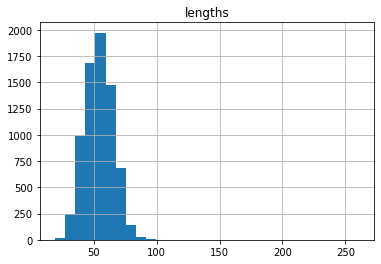

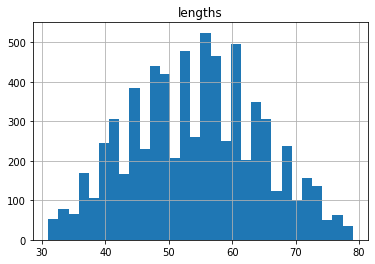

In [3]:
allchars = set("".join(list(df.smiles)))

# Let's start from 1, we will use zero for padding
char2int = dict((c,i+1) for i,c in enumerate(allchars))
int2char = dict((i+1,c) for i,c in enumerate(allchars))
df['lengths'] = [len(smile) for smile in df.smiles]

print(str(allchars))
print(len(allchars))
plot = df.hist('lengths', bins=30)
plt.show()

df_filtered = df[(df.lengths < 80) & (df.lengths > 30)].copy()
df_filtered.hist('lengths', bins=30)
plt.show()

In [4]:
max_len = np.max(df_filtered.lengths)
char_vec = np.zeros((df_filtered.smiles.shape[0], max_len),dtype=np.int8)
for i,smile in enumerate(df_filtered.smiles):
    for j,char in enumerate(smile):
        char_vec[i,j] = char2int[char]
char_vec = [vec for vec in char_vec]
df_filtered['char_vec'] = char_vec

### Morgan fingerprint

In [20]:
mols = [Chem.MolFromSmiles(smi) for smi in df_filtered.smiles]
mfps_1024_2 = [AllChem.GetMorganFingerprintAsBitVect(m, 2, 1024) for m in mols]
    
df_filtered['mfps_1024_2'] = mfps_1024_2

In [21]:
mols = [Chem.MolFromSmiles(smi) for smi in df_filtered.smiles]
mfps_1024_4 = [AllChem.GetMorganFingerprintAsBitVect(m, 4, 1024) for m in mols]
    
df_filtered['mfps_1024_4'] = mfps_1024_4

In [22]:
mols = [Chem.MolFromSmiles(smi) for smi in df_filtered.smiles]
mfps_2048_2 = [AllChem.GetMorganFingerprintAsBitVect(m, 2, 2048) for m in mols]
    
df_filtered['mfps_2048_2'] = mfps_2048_2

In [23]:
mols = [Chem.MolFromSmiles(smi) for smi in df_filtered.smiles]
mfps_2048_4 = [AllChem.GetMorganFingerprintAsBitVect(m, 4, 2048) for m in mols]
    
df_filtered['mfps_2048_4'] = mfps_2048_4

### MACC'S

In [9]:
maccs_fps = [Chem.MACCSkeys.GenMACCSKeys(mol) for mol in mols]
np_maccs_fps = []
    
df_filtered['maccs_fps'] = maccs_fps

### dimension reduction by PCA

In [10]:
pca = PCA(0.9)

### Save the DataFrame

In [11]:
# We can't save the dataframe to csv bcs we wont to preserve the datastructure of fingerprints
#joblib.dump(df, 'data/df_VEGF2_mfps_maccs.sav')
#print('DataFrame was saved')
joblib.dump(df_filtered, 'data/df_VEGF2_mfps_maccs_filtered_by_length.sav')
print('DataFrame was saved')

DataFrame was saved


# Regression with XGBoost

In [13]:
def get_tuned_model(X, y,):      
    params = {
            'min_child_weight': [1, 5, 10],
            'gamma': [0.1, 0.5, 1, 1.5,],
            'subsample': [0.6, 0.8, 1.0],
            'colsample_bytree': [0.6, 0.8, 1.0],
            'n_estimators' : [100, 300, 400, 500, 600],
            'max_depth': [3, 4, 5]
            }
    
    xg_reg = XGBRegressor(objective='reg:squarederror', seed=0)
    kf = KFold(n_splits=5, shuffle=True, random_state=0)
    random_search = RandomizedSearchCV(xg_reg, 
                                       param_distributions=params, 
                                       n_iter=5,
                                       scoring='neg_mean_absolute_error', 
                                       n_jobs=-1, 
                                       cv=kf, 
                                       verbose=3, 
                                       random_state=0)

    random_search.fit(train_X, train_y)
    print('best params for fp type ' + fp_type, random_search.best_params_)
    print('best score %.3f' %(np.abs(random_search.best_score_)))
          
    return random_search.best_estimator_

In [24]:
all_scores = []
all_models = []
scaler = MinMaxScaler()
fps_types = ['char_vec', 'char_vec', 'maccs_fps', 'maccs_fps', 
            'mfps_1024_2', 'mfps_1024_4', 'mfps_2048_2', 'mfps_2048_4',
            'mfps_1024_2', 'mfps_1024_4', 'mfps_2048_2', 'mfps_2048_4']
counter = 0
to_pca = [3, 8, 9, 10, 11]
to_transform = [1]
for fp_type in fps_types:
    
    X = [val for val in df_filtered[fp_type]]
    y = df_filtered.ds
    train_X, test_X, train_y, test_y = train_test_split(X, y,
                      test_size = 0.3, random_state = 0)
    
    if counter in to_transform:
        train_X = scaler.fit_transform(train_X)
        test_X = scaler.transform(test_X)
        
    if counter in to_pca:
        train_X = pca.fit_transform(train_X)
        test_X = pca.transform(test_X)
    
    # get model with best hyperparameters
    model = get_tuned_model(X, y)
    cv = RepeatedKFold(n_splits=5, n_repeats=2, random_state=1)
    # evaluate the model
    scores = cross_val_score(model, train_X, train_y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
    all_scores.append(scores)
    print('Mean MSE: %.3f (%.3f)' % (np.abs(scores).mean(), scores.std()) )
    
    # train the model on the whole trainset
    model.fit(train_X, train_y)
    all_models.append(model)
    counter += 1

Fitting 5 folds for each of 5 candidates, totalling 25 fits
best params for fp type char_vec {'subsample': 0.8, 'n_estimators': 600, 'min_child_weight': 10, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 0.8}
best score 0.731
Mean MSE: 0.742 (0.015)
Fitting 5 folds for each of 5 candidates, totalling 25 fits
best params for fp type char_vec {'subsample': 0.8, 'n_estimators': 600, 'min_child_weight': 10, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 0.8}
best score 0.729
Mean MSE: 0.743 (0.015)
Fitting 5 folds for each of 5 candidates, totalling 25 fits
best params for fp type maccs_fps {'subsample': 0.8, 'n_estimators': 600, 'min_child_weight': 10, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 0.8}
best score 0.580
Mean MSE: 0.579 (0.022)
Fitting 5 folds for each of 5 candidates, totalling 25 fits
best params for fp type maccs_fps {'subsample': 0.8, 'n_estimators': 600, 'min_child_weight': 10, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 0.8}
best score 0.674
Mean MSE: 

[CV 2/5] END colsample_bytree=1.0, gamma=0.5, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.8;, score=-0.742 total time=  29.7s
[CV 4/5] END colsample_bytree=0.8, gamma=1, max_depth=3, min_child_weight=5, n_estimators=500, subsample=0.8;, score=-0.745 total time= 2.2min
[CV 2/5] END colsample_bytree=0.8, gamma=0.5, max_depth=3, min_child_weight=1, n_estimators=500, subsample=0.6;, score=-0.730 total time= 2.0min
[CV 5/5] END colsample_bytree=1.0, gamma=0.5, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.8;, score=-0.649 total time=  33.6s
[CV 5/5] END colsample_bytree=0.8, gamma=1, max_depth=3, min_child_weight=5, n_estimators=500, subsample=0.8;, score=-0.593 total time= 2.1min
[CV 2/5] END colsample_bytree=0.8, gamma=0.5, max_depth=3, min_child_weight=1, n_estimators=500, subsample=0.6;, score=-0.703 total time= 2.1min
[CV 5/5] END colsample_bytree=1.0, gamma=0.5, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.8;, score=-0.584 total ti

[CV 3/5] END colsample_bytree=0.8, gamma=0.1, max_depth=3, min_child_weight=5, n_estimators=300, subsample=0.8;, score=-0.755 total time= 1.3min
[CV 5/5] END colsample_bytree=0.8, gamma=0.5, max_depth=4, min_child_weight=10, n_estimators=600, subsample=0.8;, score=-0.742 total time= 2.0min
[CV 2/5] END colsample_bytree=0.8, gamma=0.1, max_depth=3, min_child_weight=5, n_estimators=300, subsample=0.8;, score=-0.716 total time= 2.0min
[CV 1/5] END colsample_bytree=0.8, gamma=1, max_depth=3, min_child_weight=5, n_estimators=500, subsample=0.8;, score=-0.603 total time= 2.6min
[CV 3/5] END colsample_bytree=0.8, gamma=1, max_depth=3, min_child_weight=5, n_estimators=500, subsample=0.8;, score=-0.686 total time= 2.1min
[CV 2/5] END colsample_bytree=1.0, gamma=0.5, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.8;, score=-0.580 total time=  53.7s
[CV 4/5] END colsample_bytree=0.8, gamma=1, max_depth=3, min_child_weight=5, n_estimators=500, subsample=0.8;, score=-0.548 total tim

/home/clarovak/.conda/envs/adapters-trf/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


best params for fp type mfps_1024_2 {'subsample': 0.8, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 3, 'gamma': 0.1, 'colsample_bytree': 0.8}
best score 0.621
Mean MSE: 0.626 (0.017)
Fitting 5 folds for each of 5 candidates, totalling 25 fits
best params for fp type mfps_1024_4 {'subsample': 0.8, 'n_estimators': 500, 'min_child_weight': 5, 'max_depth': 3, 'gamma': 1, 'colsample_bytree': 0.8}
best score 0.623
Mean MSE: 0.628 (0.015)
Fitting 5 folds for each of 5 candidates, totalling 25 fits
best params for fp type mfps_2048_2 {'subsample': 0.8, 'n_estimators': 600, 'min_child_weight': 10, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 0.8}
best score 0.619
Mean MSE: 0.617 (0.013)
[CV 5/5] END colsample_bytree=0.8, gamma=0.1, max_depth=3, min_child_weight=5, n_estimators=300, subsample=0.8;, score=-0.735 total time= 1.3min
[CV 4/5] END colsample_bytree=0.8, gamma=0.5, max_depth=4, min_child_weight=10, n_estimators=600, subsample=0.8;, score=-0.727 total time= 2.0min
[CV 3

/home/clarovak/.conda/envs/adapters-trf/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


best params for fp type mfps_2048_4 {'subsample': 0.8, 'n_estimators': 600, 'min_child_weight': 10, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 0.8}
best score 0.626
[CV 3/5] END colsample_bytree=1.0, gamma=0.5, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.8;, score=-0.646 total time=  39.8s
[CV 4/5] END colsample_bytree=0.8, gamma=1, max_depth=3, min_child_weight=5, n_estimators=500, subsample=0.8;, score=-0.605 total time= 2.7min
[CV 2/5] END colsample_bytree=0.8, gamma=0.5, max_depth=3, min_child_weight=1, n_estimators=500, subsample=0.6;, score=-0.633 total time= 3.4min
[CV 4/5] END colsample_bytree=1.0, gamma=0.5, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.8;, score=-0.620 total time=  50.7s
[CV 3/5] END colsample_bytree=0.8, gamma=0.5, max_depth=4, min_child_weight=10, n_estimators=600, subsample=0.8;, score=-0.626 total time= 3.7min
[CV 1/5] END colsample_bytree=0.8, gamma=0.5, max_depth=3, min_child_weight=1, n_estimators=500, subsamp

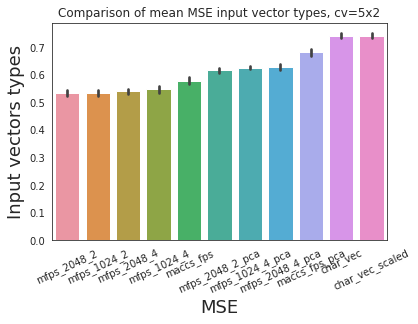

In [46]:
df_results = pd.DataFrame(np.abs(all_scores)).T
df_results.columns = ['char_vec', 'char_vec_scaled', 'maccs_fps', 'maccs_fps_pca', 
            'mfps_1024_2', 'mfps_1024_4', 'mfps_2048_2', 'mfps_2048_4',
            'mfps_1024_4_pca', 'mfps_1024_4_pca', 'mfps_2048_2_pca', 'mfps_2048_4_pca']

df_res_mean_std = pd.DataFrame({'mean MSE':df_results.mean(),
                       'std MSE':df_results.std()}).sort_values('mean MSE')
cols_sorted_by_mse = df_res_mean_std.index
df_results = df_results[cols_sorted_by_mse]

df_res_melted = pd.melt(df_results, value_name='MSE', var_name='vec_type')

sns.set_style("white")
sns.set_palette('viridis')
sns.barplot(data=df_res_melted, x='vec_type', y='MSE')
plt.ylabel('MSE',  fontsize=18)
plt.xlabel('Input vectors types',  fontsize=18)
plt.title('Comparison of mean MSE input vector types, cv=5x2', fontsize)
plt.xticks(rotation=25)
plt.show()

In [36]:
df_res_mean_std

,mean MSE,std MSE
mfps_2048_2,0.534641,0.016397
mfps_1024_2,0.535977,0.019268
mfps_2048_4,0.540405,0.017045
mfps_1024_4,0.548256,0.020477
maccs_fps,0.578851,0.023511
mfps_2048_2_pca,0.617153,0.013727
mfps_1024_4_pca,0.625716,0.017885
mfps_1024_4_pca,0.627638,0.015568
mfps_2048_4_pca,0.628704,0.020475
maccs_fps_pca,0.682336,0.021236


## Simona's data

In [15]:
df = pd.read_csv('data/tokenized_data.csv')
for name in df.columns[1:]:
    df[name] =  [[ int(i) for i in item.strip('[]').split(' ') if i != ''] for item in df[name]]
    
df

,value,canonical_smiles_tokenIndexList,sln_tokenIndexList,deep_smiles_tokenIndexList,selfies_tokenIndexList,inchi_tokenIndexList
0,7.320,"[639, 522, 58, 1040, 2364, 1534, 631, 1126, 23...","[472, 125, 418, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2469, 315, 33, 1790, 3257, 155, 1838, 1266, 2...","[32, 30, 35, 24, 12, 20, 39, 20, 12, 34, 12, 2...","[3015, 2445, 32, 2079, 1525, 2091, 2624, 3953,..."
1,6.750,"[639, 3120, 689, 2601, 2364, 1255, 631, 1568, ...","[472, 623, 96, 14, 288, 83, 329, 624, 519, 624...","[2469, 1554, 2156, 3902, 2302, 560, 3529, 3020...","[32, 30, 35, 20, 12, 34, 12, 20, 12, 34, 12, 2...","[3015, 4298, 1525, 3406, 2624, 1860, 2624, 159..."
2,6.420,"[639, 3120, 689, 2601, 2364, 2269, 631, 1568, ...","[472, 623, 96, 14, 288, 83, 329, 624, 519, 624...","[2469, 1554, 2156, 4026, 2302, 560, 3529, 3020...","[32, 30, 35, 20, 12, 34, 12, 20, 12, 34, 12, 2...","[3015, 603, 1525, 1951, 2624, 4799, 2624, 1596..."
3,7.850,"[639, 1150, 2364, 2024, 689, 1337, 631, 860, 6...","[472, 623, 96, 128, 288, 83, 329, 508, 519, 39...","[2469, 1259, 2156, 2946, 258, 2655, 258, 1169,...","[32, 30, 35, 20, 12, 34, 12, 20, 12, 34, 12, 2...","[3015, 476, 1525, 2646, 2624, 2638, 2624, 1596..."
4,7.150,"[639, 1107, 2364, 3031, 631, 2344, 558, 0, 0, ...","[472, 623, 96, 395, 288, 32, 329, 624, 519, 39...","[2469, 3218, 1438, 2655, 339, 0, 0, 0, 0, 0, 0...","[32, 30, 35, 20, 12, 34, 12, 20, 21, 34, 12, 2...","[3015, 3269, 1525, 1658, 2624, 5002, 2624, 379..."
...,...,...,...,...,...,...
7154,6.440,"[639, 2095, 2364, 153, 2682, 1276, 3064, 3043,...","[472, 379, 96, 14, 288, 32, 329, 624, 519, 242...","[2469, 3347, 1661, 775, 1903, 3112, 1438, 1591...","[32, 30, 12, 34, 12, 20, 21, 34, 12, 20, 19, 2...","[3015, 4780, 1525, 2091, 2624, 4847, 2624, 479..."
7155,7.700,"[639, 879, 689, 2701, 689, 452, 2364, 309, 631...","[472, 379, 96, 14, 288, 32, 329, 508, 519, 624...","[2469, 252, 2156, 844, 2156, 1784, 750, 3020, ...","[32, 30, 12, 34, 12, 20, 21, 34, 12, 20, 12, 2...","[3015, 780, 1525, 2091, 2624, 4847, 2624, 5011..."
7156,5.470,"[639, 879, 2364, 2511, 112, 1589, 2364, 2959, ...","[472, 379, 96, 14, 288, 32, 329, 508, 519, 339...","[2469, 3380, 2156, 2805, 2467, 542, 750, 2444,...","[32, 30, 12, 34, 12, 20, 21, 34, 12, 20, 12, 2...","[3015, 2859, 1525, 2091, 2624, 4576, 2624, 479..."
7157,5.525,"[639, 879, 2364, 1743, 112, 1589, 2364, 2959, ...","[472, 379, 96, 14, 288, 32, 329, 508, 519, 535...","[2469, 2579, 2156, 2805, 2467, 2214, 1960, 775...","[32, 30, 12, 34, 12, 20, 21, 34, 12, 20, 12, 2...","[3015, 1968, 1525, 2091, 2624, 4847, 2624, 500..."


<AxesSubplot:>

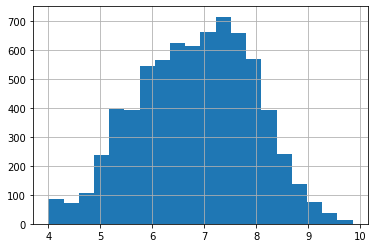

In [16]:
df.value.hist(bins=20)

In [17]:
def remove_zeroes(List, n):
    try:
        while True:
            List.remove(n)
    except ValueError:
        pass
    
df_noZeroes = pd.DataFrame()
for name in df.columns[1:]:
    df_noZeroes[name] =  [remove_zeroes(item, 0) for item in df[name].copy()]
    
df

,value,canonical_smiles_tokenIndexList,sln_tokenIndexList,deep_smiles_tokenIndexList,selfies_tokenIndexList,inchi_tokenIndexList
0,7.320,"[639, 522, 58, 1040, 2364, 1534, 631, 1126, 23...","[472, 125, 418]","[2469, 315, 33, 1790, 3257, 155, 1838, 1266, 2...","[32, 30, 35, 24, 12, 20, 39, 20, 12, 34, 12, 2...","[3015, 2445, 32, 2079, 1525, 2091, 2624, 3953,..."
1,6.750,"[639, 3120, 689, 2601, 2364, 1255, 631, 1568, ...","[472, 623, 96, 14, 288, 83, 329, 624, 519, 624...","[2469, 1554, 2156, 3902, 2302, 560, 3529, 3020...","[32, 30, 35, 20, 12, 34, 12, 20, 12, 34, 12, 2...","[3015, 4298, 1525, 3406, 2624, 1860, 2624, 159..."
2,6.420,"[639, 3120, 689, 2601, 2364, 2269, 631, 1568, ...","[472, 623, 96, 14, 288, 83, 329, 624, 519, 624...","[2469, 1554, 2156, 4026, 2302, 560, 3529, 3020...","[32, 30, 35, 20, 12, 34, 12, 20, 12, 34, 12, 2...","[3015, 603, 1525, 1951, 2624, 4799, 2624, 1596..."
3,7.850,"[639, 1150, 2364, 2024, 689, 1337, 631, 860, 6...","[472, 623, 96, 128, 288, 83, 329, 508, 519, 39...","[2469, 1259, 2156, 2946, 258, 2655, 258, 1169,...","[32, 30, 35, 20, 12, 34, 12, 20, 12, 34, 12, 2...","[3015, 476, 1525, 2646, 2624, 2638, 2624, 1596..."
4,7.150,"[639, 1107, 2364, 3031, 631, 2344, 558]","[472, 623, 96, 395, 288, 32, 329, 624, 519, 39...","[2469, 3218, 1438, 2655, 339]","[32, 30, 35, 20, 12, 34, 12, 20, 21, 34, 12, 2...","[3015, 3269, 1525, 1658, 2624, 5002, 2624, 379..."
...,...,...,...,...,...,...
7154,6.440,"[639, 2095, 2364, 153, 2682, 1276, 3064, 3043,...","[472, 379, 96, 14, 288, 32, 329, 624, 519, 242...","[2469, 3347, 1661, 775, 1903, 3112, 1438, 1591...","[32, 30, 12, 34, 12, 20, 21, 34, 12, 20, 19, 2...","[3015, 4780, 1525, 2091, 2624, 4847, 2624, 479..."
7155,7.700,"[639, 879, 689, 2701, 689, 452, 2364, 309, 631...","[472, 379, 96, 14, 288, 32, 329, 508, 519, 624...","[2469, 252, 2156, 844, 2156, 1784, 750, 3020, ...","[32, 30, 12, 34, 12, 20, 21, 34, 12, 20, 12, 2...","[3015, 780, 1525, 2091, 2624, 4847, 2624, 5011..."
7156,5.470,"[639, 879, 2364, 2511, 112, 1589, 2364, 2959, ...","[472, 379, 96, 14, 288, 32, 329, 508, 519, 339...","[2469, 3380, 2156, 2805, 2467, 542, 750, 2444,...","[32, 30, 12, 34, 12, 20, 21, 34, 12, 20, 12, 2...","[3015, 2859, 1525, 2091, 2624, 4576, 2624, 479..."
7157,5.525,"[639, 879, 2364, 1743, 112, 1589, 2364, 2959, ...","[472, 379, 96, 14, 288, 32, 329, 508, 519, 535...","[2469, 2579, 2156, 2805, 2467, 2214, 1960, 775...","[32, 30, 12, 34, 12, 20, 21, 34, 12, 20, 12, 2...","[3015, 1968, 1525, 2091, 2624, 4847, 2624, 500..."


[CV 5/5] END colsample_bytree=0.8, gamma=0.1, max_depth=3, min_child_weight=5, n_estimators=300, subsample=0.8;, score=-0.725 total time= 1.8min
[CV 5/5] END colsample_bytree=0.8, gamma=0.5, max_depth=4, min_child_weight=10, n_estimators=600, subsample=0.8;, score=-0.730 total time= 1.5min
[CV 3/5] END colsample_bytree=0.8, gamma=0.1, max_depth=3, min_child_weight=5, n_estimators=300, subsample=0.8;, score=-0.777 total time= 1.1min
[CV 4/5] END colsample_bytree=1.0, gamma=0.5, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.8;, score=-0.656 total time=  34.8s
[CV 5/5] END colsample_bytree=0.8, gamma=1, max_depth=3, min_child_weight=5, n_estimators=500, subsample=0.8;, score=-0.593 total time= 2.2min
[CV 3/5] END colsample_bytree=1.0, gamma=0.5, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.8;, score=-0.582 total time= 1.3min
[CV 3/5] END colsample_bytree=0.8, gamma=0.5, max_depth=4, min_child_weight=10, n_estimators=600, subsample=0.8;, score=-0.532 tota

[CV 3/5] END colsample_bytree=0.8, gamma=0.5, max_depth=3, min_child_weight=1, n_estimators=500, subsample=0.6;, score=-0.766 total time= 2.6min
[CV 3/5] END colsample_bytree=0.8, gamma=0.5, max_depth=3, min_child_weight=1, n_estimators=500, subsample=0.6;, score=-0.771 total time= 2.5min
[CV 3/5] END colsample_bytree=1.0, gamma=0.5, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.8;, score=-0.667 total time=  45.8s
[CV 1/5] END colsample_bytree=0.8, gamma=0.5, max_depth=4, min_child_weight=10, n_estimators=600, subsample=0.8;, score=-0.585 total time= 2.6min
[CV 1/5] END colsample_bytree=0.8, gamma=0.1, max_depth=3, min_child_weight=5, n_estimators=300, subsample=0.8;, score=-0.566 total time= 2.6min
[CV 1/5] END colsample_bytree=0.8, gamma=0.1, max_depth=3, min_child_weight=5, n_estimators=300, subsample=0.8;, score=-0.672 total time= 1.2min
[CV 4/5] END colsample_bytree=0.8, gamma=0.5, max_depth=4, min_child_weight=10, n_estimators=600, subsample=0.8;, score=-0.668 to

[CV 4/5] END colsample_bytree=0.8, gamma=0.1, max_depth=3, min_child_weight=5, n_estimators=300, subsample=0.8;, score=-0.750 total time= 1.8min
[CV 5/5] END colsample_bytree=1.0, gamma=0.5, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.8;, score=-0.743 total time=  42.3s
[CV 3/5] END colsample_bytree=0.8, gamma=0.5, max_depth=4, min_child_weight=10, n_estimators=600, subsample=0.8;, score=-0.747 total time= 2.5min
[CV 3/5] END colsample_bytree=0.8, gamma=0.1, max_depth=3, min_child_weight=5, n_estimators=300, subsample=0.8;, score=-0.616 total time= 2.1min
[CV 5/5] END colsample_bytree=1.0, gamma=0.5, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.8;, score=-0.599 total time= 1.3min
[CV 2/5] END colsample_bytree=0.8, gamma=0.5, max_depth=4, min_child_weight=10, n_estimators=600, subsample=0.8;, score=-0.540 total time= 3.8min
[CV 2/5] END colsample_bytree=0.8, gamma=0.5, max_depth=3, min_child_weight=1, n_estimators=500, subsample=0.6;, score=-0.691 to

24.12571588210644
57.56208967732923
18.392512920798993
110.00963821762817


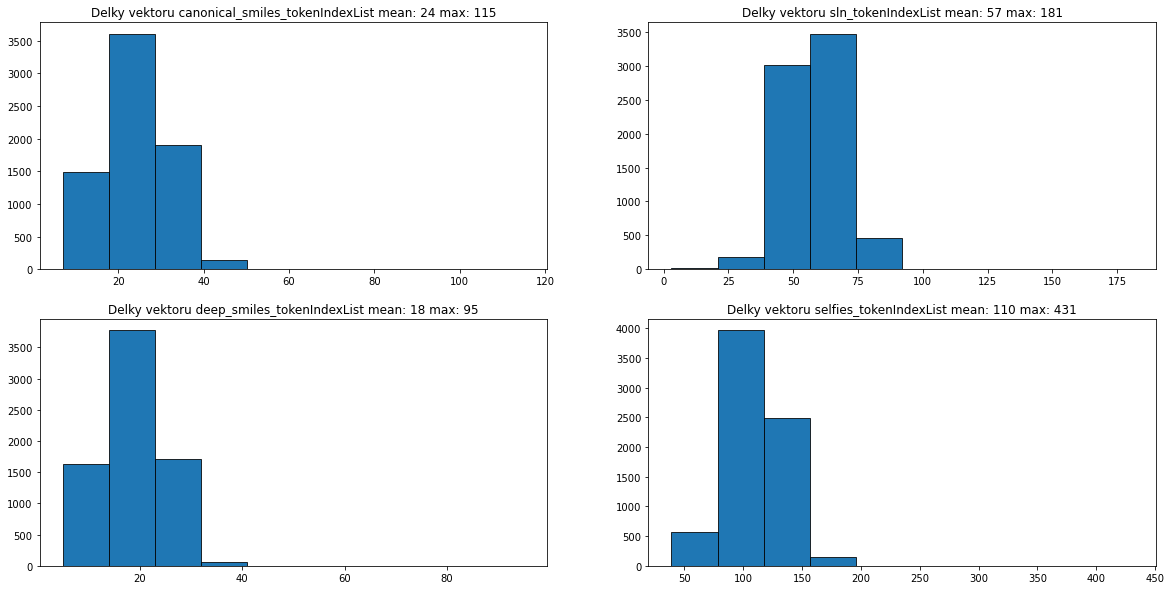

In [75]:
plt.figure(figsize=(20,10))

for i in range(4):
    name = df.columns[i+1]
    lengths = [len(l) for l in df[name]]
    df['len_'+name] = lengths
    print(np.sum(lengths)/df.shape[0])
    
    plt.subplot(2, 2, i+1)
    plt.hist(lengths, bins=10, edgecolor='black', linewidth=0.8)
    plt.title('Delky vektoru '+name+' mean: '+str(int(np.mean(lengths)))+' max: '+str(np.max(lengths)))

In [79]:
df.columns

Index(['value', 'canonical_smiles_tokenIndexList', 'sln_tokenIndexList',
       'deep_smiles_tokenIndexList', 'selfies_tokenIndexList',
       'inchi_tokenIndexList', 'len_canonical_smiles_tokenIndexList',
       'len_sln_tokenIndexList', 'len_deep_smiles_tokenIndexList',
       'len_selfies_tokenIndexList'],
      dtype='object')

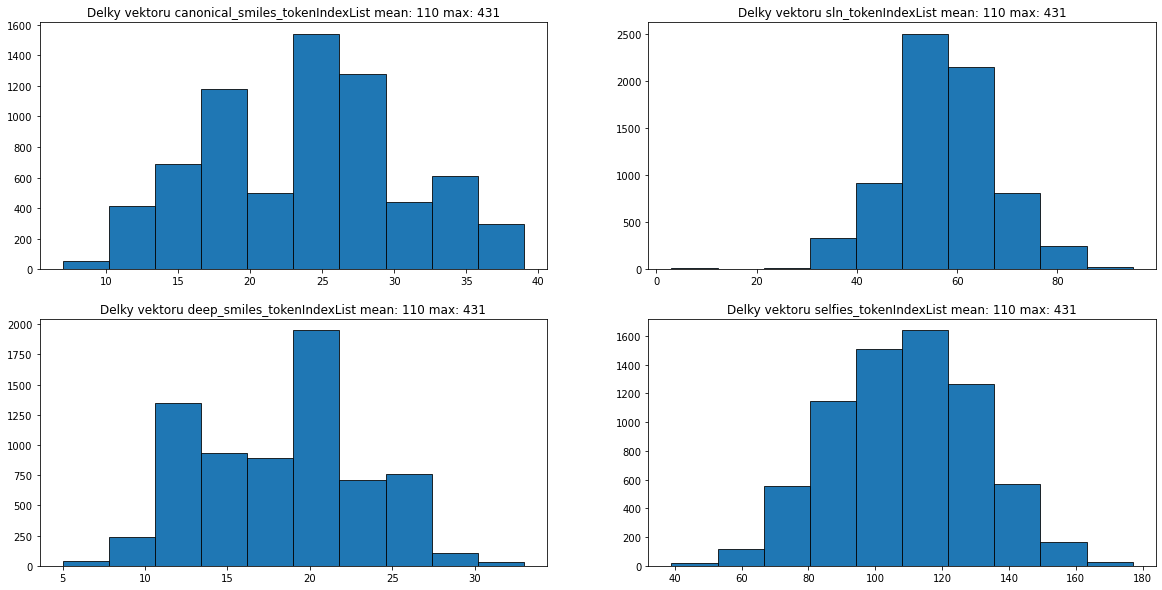

In [81]:
plt.figure(figsize=(20,10))

new_df = pd.DataFrame()

for i in range(4):
    name = df.columns[i+1]
    
    plt.subplot(2, 2, i+1)
    plt.hist(df['len_'+name], bins=10, edgecolor='black', linewidth=0.8)
    plt.title('Delky vektoru '+name+' mean: '+str(int(np.mean(lengths)))+' max: '+str(np.max(lengths)))

In [147]:
df = df.reset_index(drop=True)
df = df[df.columns[1:]]
df.columns

Index(['value', 'canonical_smiles_tokenIndexList', 'sln_tokenIndexList',
       'deep_smiles_tokenIndexList', 'selfies_tokenIndexList',
       'inchi_tokenIndexList', 'len_canonical_smiles_tokenIndexList',
       'len_sln_tokenIndexList', 'len_deep_smiles_tokenIndexList',
       'len_selfies_tokenIndexList'],
      dtype='object')

In [148]:
df.to_csv('data/tokenized_data_filtered.csv', index=False)

In [98]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [121]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

X =  np.array([np.array(x) for x in df[df.columns[4]].values])
X = pad_sequences(X, padding="post")
y = df[df.columns[0]].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)
X.shape

/home/clarovak/.conda/envs/trf/lib/python3.6/site-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


(7002, 177)

In [118]:
#sc = MinMaxScaler(feature_range = (0, 1))
#X_scaled = sc.fit_transform(X)




## GBoost

In [2]:
from scipy.stats import randint as sp_randInt
from scipy.stats import uniform as sp_randFloat
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor

In [32]:
model = GradientBoostingRegressor()
parameters = {"learning_rate": sp_randFloat(),
              "subsample"    : sp_randFloat(),
              "n_estimators" : sp_randInt(100, 1000),
              "max_depth"    : sp_randInt(4, 10)
             }
randm = RandomizedSearchCV(estimator=model, param_distributions = parameters,
                               cv = 2, n_iter = 10, n_jobs=-1)
randm.fit(X_train, y_train)

RandomizedSearchCV(cv=2, estimator=GradientBoostingRegressor(), n_jobs=-1,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f98c83fa4e0>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f98c83fa978>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f98c83fac50>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f98c83faac8>})

Text(0.5, 1.0, 'True vs preds, mse: 0.88')

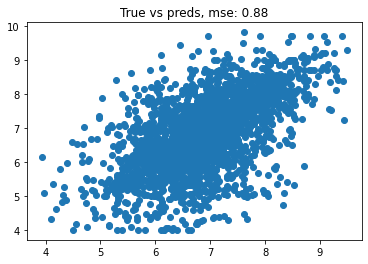

In [33]:
reg = randm.best_estimator_
reg.fit(X_train, y_train)
preds = reg.predict(X_test)
plt.scatter(preds, y_test)
mse = mean_squared_error(preds, y_test)
plt.title('True vs preds, mse: {:.2f}'.format(mse))

In [34]:
mean_squared_error(preds, y_test, squared=False)

0.9354914703177916

## NN MODEL

In [58]:
size = len(X[0])
def nn_model():
    # create model
    model = Sequential()
    model.add(Dense(size, input_dim=size, kernel_initializer='normal', activation='relu'))
    model.add(Dense(int(size/2), activation='relu'))
    model.add(Dense(1, kernel_initializer='normal',activation='linear'))
    # Compile the model 
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.summary()
    return model

In [59]:
model = nn_model()
history = model.fit(X_train,y_train,epochs=40,batch_size=64,verbose=2, validation_data=(X_test, y_test))

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 39)                1560      
_________________________________________________________________
dense_31 (Dense)             (None, 19)                760       
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 20        
Total params: 2,340
Trainable params: 2,340
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
74/74 - 1s - loss: 84.1228 - val_loss: 9.7505
Epoch 2/40
74/74 - 0s - loss: 5.7773 - val_loss: 4.6038
Epoch 3/40
74/74 - 0s - loss: 3.3693 - val_loss: 3.2516
Epoch 4/40
74/74 - 0s - loss: 2.6364 - val_loss: 2.6872
Epoch 5/40
74/74 - 0s - loss: 2.2744 - val_loss: 2.4448
Epoch 6/40
74/74 - 0s - loss: 2.0820 - val_loss: 2.3225
Epoch 7/40
74/74 - 0s - loss: 2.0259 - val_lo

Text(0.5, 1.0, 'True vs preds, mse: 1.77')

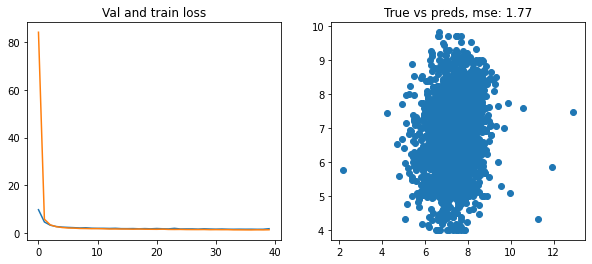

In [60]:
plt.figure(figsize=(10,4))

plt.subplot(121)
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.title('Val and train loss')
plt.subplot(122)
preds = model.predict(X_test)
plt.scatter(preds, y_test)
mse = mean_squared_error(preds, y_test)
plt.title('True vs preds, mse: {:.2f}'.format(mse))


## LSTM MODEL

In [86]:
from keras import optimizers

def lstm_bi_model():
    input1 = Input(shape=(len(X[0]),1)) #last two values
    lstm1 = Bidirectional(LSTM(units=128))(input1)
    #dnn_hidden_layer1 = Dense(128, activation='relu')(lstm1)
    dnn_output = Dense(1, activation='linear')(lstm1)
    model = Model(inputs=[input1],outputs=[dnn_output])
    # compile the model
    opt = optimizers.Adam(learning_rate=0.0001)
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
    model.summary()
    return model


In [134]:
def lstm_uni_model():
    model = Sequential()
    model.add(LSTM(64,return_sequences=True, input_shape=(len(X[0]),1)))
    model.add(Dropout(0.5))
    model.add(LSTM(20,return_sequences=False))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='rmsprop')
    model.summary()
    return model

In [87]:
X = np.reshape(X, (X.shape[0],X.shape[1],1))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

In [88]:
model = lstm_model()
history = model.fit(X_train,y_train,epochs=10,batch_size=128, verbose=2, validation_data=(X_test, y_test))

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 39, 1)]           0         
_________________________________________________________________
bidirectional_6 (Bidirection (None, 256)               133120    
_________________________________________________________________
dense_45 (Dense)             (None, 1)                 257       
Total params: 133,377
Trainable params: 133,377
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
37/37 - 9s - loss: 10.9423 - mean_squared_error: 10.9423 - val_loss: 1.7979 - val_mean_squared_error: 1.7979
Epoch 2/10
37/37 - 5s - loss: 1.5285 - mean_squared_error: 1.5285 - val_loss: 1.3183 - val_mean_squared_error: 1.3183
Epoch 3/10
37/37 - 4s - loss: 1.2520 - mean_squared_error: 1.2520 - val_loss: 1.2840 - val_mean_squared_error: 1.2840
Epoch 4/10
37/37 - 5s - los

Text(0.5, 1.0, 'True vs preds, mse: 1.21')

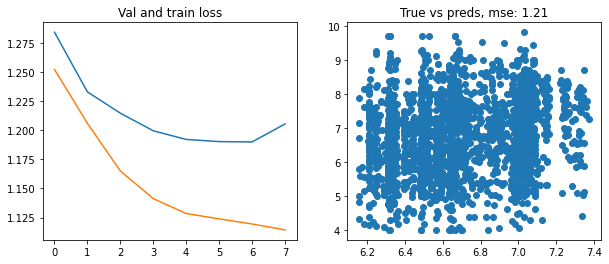

In [89]:
plt.figure(figsize=(10,4))

plt.subplot(121)
plt.plot(history.history['val_loss'][2:])
plt.plot(history.history['loss'][2:])
plt.title('Val and train loss')
plt.subplot(122)
preds = model.predict(X_test)
plt.scatter(preds, y_test)
mse = mean_squared_error(preds, y_test)
mse
plt.title('True vs preds, mse: {:.2f}'.format(mse))

## ONEHOT

In [3]:
with open('data/deep_smiles_oh.npy', 'rb') as fin:
    data = np.load(fin)
    tokenized = np.load(fin, allow_pickle=True)
    y = np.load(fin)
    
data.shape, tokenized.shape, y.shape

((7044, 60, 54), (7044,), (7044,))

In [34]:
from tensorflow.keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasRegressor


'''
def lstm_bi_model(neurons1=32, neurons2=32,lr=0.001):
    input1 = Input(shape=(X_train.shape[1],X_train.shape[2])) #last two values
    lstm1 = Bidirectional(LSTM(units=neurons1))(input1)
    dnn_hidden_layer1 = Dense(neurons2, activation='relu')(lstm1)
    dnn_output = Dense(1, activation='linear')(dnn_hidden_layer1)
    model = Model(inputs=[input1],outputs=[dnn_output])
    # compile model
    optimizer = 'adam' #Adam(learning_rate=lr)
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mean_squared_error'])
    model.summary()
    return model'''

def lstm_bi_model(layers=1, neurons1=64, neurons2=64, neurons3=64, neurons4=64, lr=0.001):    
    model = Sequential()
    neurons = [neurons1, neurons2, neurons3, neurons4]
    model.add(Bidirectional(LSTM(neurons[0], return_sequences=True), 
                            input_shape=(X_train.shape[1],
                                         X_train.shape[2]), 
                            merge_mode='sum'))
    model.add(Dropout(rate=0.5))
    
    for i in range(layers):
        model.add(Dense(neurons[i+1]))
        model.add(Dropout(0.5))

    model.add(Dense(1, activation='linear'))
    # compile model
    optimizer = Adam(learning_rate=lr)
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mean_squared_error'])
    model.summary()
    return model

def lstm_uni_model():
    model = Sequential()
    model.add(LSTM(64,return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])))
    model.add(Dropout(0.5))
    model.add(LSTM(20,return_sequences=False))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='rmsprop')
    model.summary()
    return model

In [35]:
param_grid = {'lr': [0.001, 0.0001, 0.00001],
              'neurons1': [128, 256], 
    'neurons2': [128, 256], 
    'neurons3': [128, 256], 
    'neurons4': [128, 256], 
    'layers': [0,1,2,4],
    
}

In [36]:
from numpy import array
from numpy import argmax
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.preprocessing.sequence import pad_sequences


X = pad_sequences(tokenized, padding="post")

# one hot encode
encoded = to_categorical(X)
# invert encoding
inverted = argmax(encoded[0])
X_train, X_test, y_train, y_test = train_test_split(encoded, y, test_size=0.15, random_state=0)

In [37]:
model = KerasRegressor(build_fn=lstm_bi_model, epochs=30, batch_size=64, verbose=0)


grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

2022-03-14 22:38:15.801724: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:
2022-03-14 22:38:15.801797: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1835] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-03-14 22:38:15.802496: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2

2022-03-14 22:38:16.029658: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:
2022-03-14 22:38:16.029722: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1835] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-03-14 22:38:16.030390: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2

2022-03-14 22:38:17.813717: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-03-14 22:38:17.814386: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-03-14 22:38:17.815722: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-03-14 22:38:17.816712: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-03-14 22:38:17.818733: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-03-14 22:38:17.825732: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-03-14 22:38:17.828431: I tensorflow/compiler/mlir/mlir_grap

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 60, 128)           187392    
_________________________________________________________________
dropout (Dropout)            (None, 60, 128)           0         
_________________________________________________________________
dense (Dense)                (None, 60, 128)           16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 128)           0         
_________________________________________________________________
dense_1 (Dense)              (None, 60, 1)             129       
Total params: 204,033
Trainable params: 204,033
Non-trainable params: 0
_________________________________________________________________
Model: "sequential"
_________________________________________________________________
Layer (type)                 O

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 60, 128)           187392    
_________________________________________________________________
dropout (Dropout)            (None, 60, 128)           0         
_________________________________________________________________
dense (Dense)                (None, 60, 128)           16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 128)           0         
_________________________________________________________________
dense_1 (Dense)              (None, 60, 1)             129       
Total params: 204,033
Trainable params: 204,033
Non-trainable params: 0
_________________________________________________________________
Model: "sequential"
_________________________________________________________________
Layer (type)                 O

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 60, 128)           187392    
_________________________________________________________________
dropout (Dropout)            (None, 60, 128)           0         
_________________________________________________________________
dense (Dense)                (None, 60, 128)           16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 128)           0         
_________________________________________________________________
dense_1 (Dense)              (None, 60, 1)             129       
Total params: 204,033
Trainable params: 204,033
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)                

/home/clarovak/.conda/envs/adapters-trf/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
3 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/home/clarovak/.conda/envs/adapters-trf/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/clarovak/.conda/envs/adapters-trf/lib/python3.9/site-packages/keras/wrappers/scikit_learn.py", line 153, in fit
    self.model = self.build_fn(**self.filter_sk_params(self.build_fn))
  File "/var/tmp/pbs.41413.lich-compute.vscht.cz/ipykernel_2506/1

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 60, 256)           636928    
_________________________________________________________________
dropout_4 (Dropout)          (None, 60, 256)           0         
_________________________________________________________________
dense_3 (Dense)              (None, 60, 256)           65792     
_________________________________________________________________
dropout_5 (Dropout)          (None, 60, 256)           0         
_________________________________________________________________
dense_4 (Dense)              (None, 60, 256)           65792     
_________________________________________________________________
dropout_6 (Dropout)          (None, 60, 256)           0         
_________________________________________________________________
dense_5 (Dense)              (None, 60, 1)            

In [38]:
grid_result.cv_results_

{'mean_fit_time': array([1232.53899781, 1320.79002078, 1344.21482682, 1322.99174142,
        1311.97792816,    2.02487485, 1829.33074045, 1237.52800258,
        1929.18907666,  682.31267699]),
 'std_fit_time': array([9.48105618e+01, 9.64831932e+01, 1.08727105e+02, 9.78014699e+01,
        9.89770537e+01, 1.22961143e-02, 6.08867441e+01, 7.45951398e+01,
        1.26949174e+01, 1.96754509e+00]),
 'mean_score_time': array([21.50651073, 19.07700547, 14.32788603, 18.88466581, 18.16462191,
         0.        , 10.74143831, 17.98717793,  3.84110347,  6.03544736]),
 'std_score_time': array([0.95661071, 3.3693029 , 2.52236664, 3.99094804, 3.01184938,
        0.        , 3.52540195, 1.84300915, 1.04240389, 2.04568159]),
 'param_neurons4': masked_array(data=[128, 256, 256, 256, 128, 128, 128, 128, 256, 128],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_neurons3': masked_arra

In [20]:
#model = lstm_uni_model()
model = lstm_bi_model(1)
#model.fit(X_train,y_train,epochs=10,batch_size=64,verbose=1)
history = model.fit(X_train, y_train, epochs=30, batch_size=64, 
                    verbose=2, validation_data=(X_test, y_test))

fig = plt.figure(figsize=(10,4))

fig.suptitle('Dataset: '+ name, fontsize=16)
plt.subplots_adjust(top=0.8, wspace=0.3)

plt.subplot(121)
plt.plot(history.history['val_loss'][2:], label='val_loss')
plt.plot(history.history['loss'][2:], label='train_loss')
plt.xlabel('epochs')
plt.ylabel('MSE')
plt.legend()
plt.title('Val and train loss')
plt.subplot(122)
preds = model.predict(X_test)
plt.scatter(preds, y_test)
mse = mean_squared_error(y_test, preds)
r2 = r2_score(y_test, preds)
plt.xlabel('preds')
plt.ylabel('true')
plt.title('True vs preds, MSE: {:.2f}, R2 {:.2f}'.format(mse, r2))
#plt.savefig(name+'_uni_onehot.png')

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 60, 64)            30464     
_________________________________________________________________
dropout_4 (Dropout)          (None, 60, 64)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 20)                6800      
_________________________________________________________________
dropout_5 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 21        
Total params: 37,285
Trainable params: 37,285
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_4"
_________________________________________________________________
Layer (type)                

NameError: name 'name' is not defined

<Figure size 720x288 with 0 Axes>

In [145]:
encoded.shape

(7002, 177, 40)

canonical_smiles_tokenIndexList


/home/clarovak/.conda/envs/trf/lib/python3.6/site-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # This is added back by InteractiveShellApp.init_path()


Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_30 (LSTM)               (None, 39, 64)            877312    
_________________________________________________________________
dropout_2 (Dropout)          (None, 39, 64)            0         
_________________________________________________________________
lstm_31 (LSTM)               (None, 20)                6800      
_________________________________________________________________
dropout_3 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_89 (Dense)             (None, 1)                 21        
Total params: 884,133
Trainable params: 884,133
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
93/93 - 14s - loss: 7.1654 - val_loss: 1.3268
Epoch 2/20
93/93 - 9s - loss: 3.6507 - val_loss: 1.3108


/home/clarovak/.conda/envs/trf/lib/python3.6/site-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # This is added back by InteractiveShellApp.init_path()


Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_32 (LSTM)               (None, 95, 64)            182528    
_________________________________________________________________
dropout_4 (Dropout)          (None, 95, 64)            0         
_________________________________________________________________
lstm_33 (LSTM)               (None, 20)                6800      
_________________________________________________________________
dropout_5 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_90 (Dense)             (None, 1)                 21        
Total params: 189,349
Trainable params: 189,349
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
93/93 - 27s - loss: 6.5816 - val_loss: 1.3452
Epoch 2/20
93/93 - 22s - loss: 3.5349 - val_loss: 1.2907

/home/clarovak/.conda/envs/trf/lib/python3.6/site-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # This is added back by InteractiveShellApp.init_path()


Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_34 (LSTM)               (None, 33, 64)            1073664   
_________________________________________________________________
dropout_6 (Dropout)          (None, 33, 64)            0         
_________________________________________________________________
lstm_35 (LSTM)               (None, 20)                6800      
_________________________________________________________________
dropout_7 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_91 (Dense)             (None, 1)                 21        
Total params: 1,080,485
Trainable params: 1,080,485
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
93/93 - 13s - loss: 8.6285 - val_loss: 1.4414
Epoch 2/20
93/93 - 8s - loss: 3.5503 - val_loss: 1.2

/home/clarovak/.conda/envs/trf/lib/python3.6/site-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # This is added back by InteractiveShellApp.init_path()


Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_36 (LSTM)               (None, 177, 64)           26880     
_________________________________________________________________
dropout_8 (Dropout)          (None, 177, 64)           0         
_________________________________________________________________
lstm_37 (LSTM)               (None, 20)                6800      
_________________________________________________________________
dropout_9 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_92 (Dense)             (None, 1)                 21        
Total params: 33,701
Trainable params: 33,701
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
93/93 - 38s - loss: 8.0648 - val_loss: 1.3073
Epoch 2/20
93/93 - 33s - loss: 3.8021 - val_loss: 1.3017
E

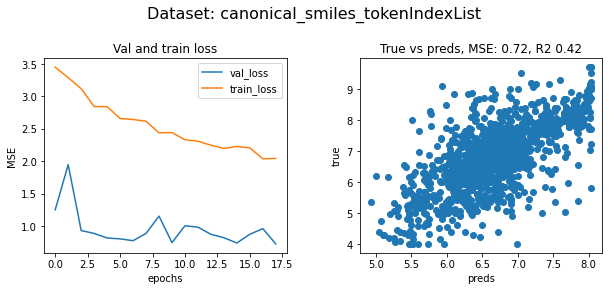

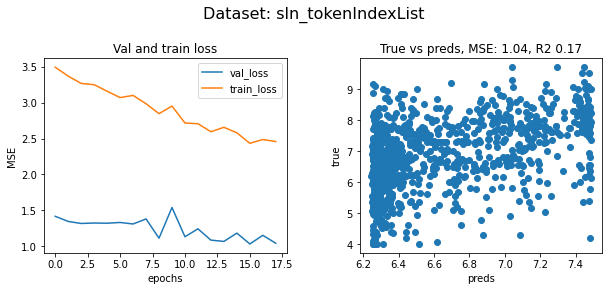

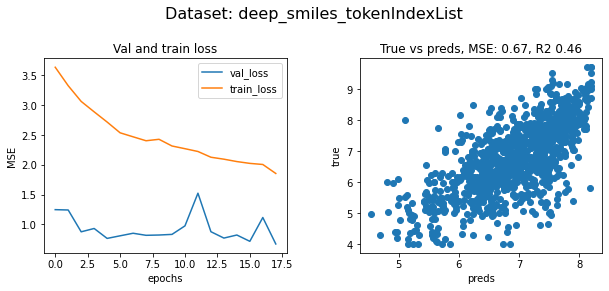

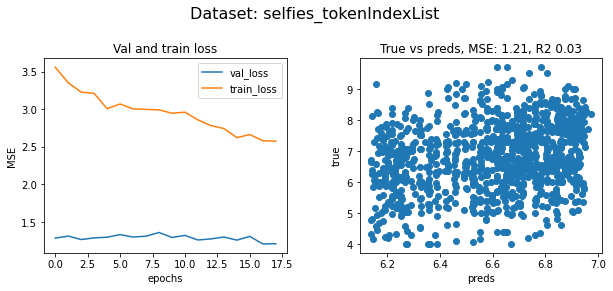

In [137]:
from numpy import array
from numpy import argmax
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.preprocessing.sequence import pad_sequences


for i in range(1,5):
    name = df.columns[i]
    print(name)
    X =  np.array([np.array(x) for x in df[name].values])
    X = pad_sequences(X, padding="post")
    y = df[df.columns[0]].values

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)
    X.shape

    # one hot encode
    encoded = to_categorical(X)
    # invert encoding
    inverted = argmax(encoded[0])
    X_train, X_test, y_train, y_test = train_test_split(encoded, y, test_size=0.15, random_state=0)

    model = lstm_uni_model()
    #model.fit(X_train,y_train,epochs=10,batch_size=64,verbose=1)
    history = model.fit(X_train,y_train,epochs=20,batch_size=64, verbose=2, validation_data=(X_test, y_test))

    fig = plt.figure(figsize=(10,4))
    
    fig.suptitle('Dataset: '+ name, fontsize=16)
    plt.subplots_adjust(top=0.8, wspace=0.3)

    plt.subplot(121)
    plt.plot(history.history['val_loss'][2:], label='val_loss')
    plt.plot(history.history['loss'][2:], label='train_loss')
    plt.xlabel('epochs')
    plt.ylabel('MSE')
    plt.legend()
    plt.title('Val and train loss')
    plt.subplot(122)
    preds = model.predict(X_test)
    plt.scatter(preds, y_test)
    mse = mean_squared_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    plt.xlabel('preds')
    plt.ylabel('true')
    plt.title('True vs preds, MSE: {:.2f}, R2 {:.2f}'.format(mse, r2))
    plt.savefig(name+'_uni_onehot.png')

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 177, 40)]         0         
_________________________________________________________________
bidirectional_15 (Bidirectio (None, 512)               608256    
_________________________________________________________________
dense_62 (Dense)             (None, 128)               65664     
_________________________________________________________________
dense_63 (Dense)             (None, 1)                 129       
Total params: 674,049
Trainable params: 674,049
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
74/74 - 38s - loss: 4.3479 - mean_squared_error: 4.3479 - val_loss: 1.2440 - val_mean_squared_error: 1.2440
Epoch 2/20
74/74 - 33s - loss: 1.2019 - mean_squared_error: 1.2019 - val_loss: 1.2484 - val_mean_squared_error: 1.2484
Epoch 3/20
7

KeyboardInterrupt: 

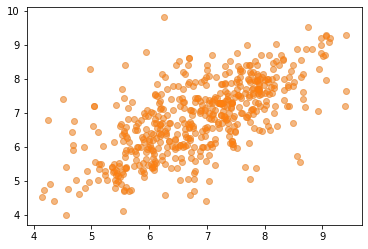

In [591]:
plt.scatter(np.array(y_pred_train.tolist()).flatten(), np.array(y_train_t.tolist()).flatten(), alpha=0.1)
plt.scatter(np.array(y_pred_test.tolist()).flatten(), np.array(y_test_t.tolist()).flatten(), alpha=0.5)